# Tutorial: Computer CPU Evolution Analysis
CMU 15688 Spring 2021


## Introduction

This tutorial introduces a dataset that contains most of the Intel's commercial CPUs data from 2005 to 2017, including prcessor series, name, release date, price, base frequency, etc. The dataset was pre-scraped from Intel's offical site. This tutorial is going to analyze and visualize how Intel CPUs have evolved over the time range using this dataset.

In order to accomplish that, this tutorial also includes a data-scraping section that extracts CPUs' benchmark scores from Geekbench. Since Geekbench can only perfrom query for one CPU name at a time, the entire data-scraping takes about 15 minutes for over 900 entries in the dataset. To make things easier, you can either enjoy the 15-minute scraping, or download the pre-scraped Geekbench data directly with the script provided.

## Setting up environment

The original CPU information dataset comes from Kaggle that contains basic information of CPUs made by Intel.
https://www.kaggle.com/iliassekkaf/computerparts?select=Intel_CPUs.csv

\
The dataset follows the exact same format that you can get from Intel's product page. For your reference, this is a sample product information page. The dataset includes all the specifications listed as well as the recommanded price.\
https://ark.intel.com/content/www/us/en/ark/products/97460/intel-pentium-processor-g4620-3m-cache-3-70-ghz.html

Run the script below to download dataset.

In [1]:
!wget -q --show-progress 'https://drive.google.com/uc?export=download&id=1ahobYKS66mL53KQhhMg8KoziKq74lToU' -O Intel_CPUs.csv

Intel_CPUs.csv      100%[===================>] 557.62K  --.-KB/s    in 0.1s    


If you prefer download the dataset manually from Kaggle, name the csv file `Intel_CPUs.csv` and put it in the same directory as the notebook.

Import packages used in this tutorial:

In [2]:
import requests
import csv
import pandas as pd
import numpy as np
import scipy as sp
import scipy.optimize
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import collections

## Preprocessing dataset

### Load information dataset and setup data format

First, load the dataset csv file to Pandas.

In [3]:
csv_file_name = 'Intel_CPUs.csv'
df = pd.read_csv(csv_file_name, header=0, sep=',', quotechar='"', dtype=str, keep_default_na=True)

The cell below contains functions used to parse the dataset. They use regular expression to convert string inputs to desired float / timestamp values.

In [4]:
# most commonly used parsing
# match any number in the input string
def search_string_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_process_node = re.compile('(\d+\.?\d*)')
    result = regex_process_node.search(input_value)
    if result == None:
        return float('nan')
    return float(result.group())

# parse frequency to float
# e.g. 800 MHz -> 0.8, 1.2 GHz -> 1.2
def search_freq_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_freq = re.compile('(\d+\.?\d*)\s?([MG]Hz)')
    result = regex_freq.search(input_value)
    if result == None:
        return float('nan')
    if result.group(2) == 'MHz':
        return float(result.group(1)) / 1000
    else:
        return float(result.group(1))

# parse price to float
# e.g. $1,234.56 -> 1234.56
def search_price_to_float(input_value):
    if pd.isna(input_value):
        return float('nan')
    regex_price = re.compile('(\d*),?(\d+.?\d*)')
    result = regex_price.search(input_value)
    if result == None:
        return float('nan')
    return float(''.join([str(x) for x in result.groups()]))

# parse release date to pandas datetime
# e.g. Q1'16 -> 2016-01-01 00:00:00, Q3'18 -> 2018-07-01 00:00:00
def launch_date_to_datetime(input_value):
    if pd.isna(input_value):
        return float('nan')
    # some data is in the format of 04'16, should be Q4'16
    # like E5-2699AV4, it was released in Oct 2016
    # interestingly this is in fact a typo on Intel's offical site
    if input_value[0] == '0':
        input_value = 'Q' + input_value[1:]
    input_value = input_value.replace(' ', '')
    return pd.to_datetime('-'.join(input_value.split("'")[::-1]))

Now, use the functions above to do the parsing work. Besides that, we want to drop entries that does not contain a CPU name: `Processor_Number` and a launch date: `Launch_Date`. We also want to drop entries that are listed as `Server` or `Embedded` use. The analysis is mostly about personal-use processors, and Geekbench most likely does not collect scores for non-personal-use processors.

In [5]:
df.dropna(subset=['Processor_Number', 'Launch_Date'], inplace=True)
df = df[~(df.Vertical_Segment == 'Server')]
df = df[~(df.Vertical_Segment == 'Embedded')]
df = df[~(df.Processor_Number.apply(lambda x: x.isnumeric()))]
df['Launch_Date'] = df['Launch_Date'].apply(lambda x: launch_date_to_datetime(x))
search_string_to_float_columns = [
    'Lithography',
    'nb_of_Cores',
    'nb_of_Threads',
    'TDP'
]
search_freq_to_float_columns = [
    'Processor_Base_Frequency',
    'Max_Turbo_Frequency'
]
for column_name in search_string_to_float_columns:
    df[column_name] = df[column_name].apply(lambda x: search_string_to_float(x))  
for column_name in search_freq_to_float_columns:
    df[column_name] = df[column_name].apply(lambda x: search_freq_to_float(x))
df['Recommended_Customer_Price'] = df['Recommended_Customer_Price'].apply(lambda x: search_price_to_float(x))
df.reset_index(drop=True, inplace=True)
print('Done')

Done


### Scrape CPU performance scores from Geekbench
Unfortunately, Intel does not release benchmark scores for their products. We can tell the relative performace from the model name, but that is not enough for our analysis. As a result, we want to find their performance scores. We will make use of Geekbench's query and scrape single-core and multi-core performace from the website. For instance, to search the example `G4620` core, the scraper is going to visit `https://browser.geekbench.com/v5/cpu/search?q=G4620` and find the result that has `G4620` in its model name. For each entry, the function `get_geekbench_score(cpu_series, cpu_name)` will return a tuple of `(single-score, multi-score)`.

In [6]:
def form_geekbench_url(cpu_name):
    query_url = 'https://browser.geekbench.com/v5/cpu/search?q='
    query_url += cpu_name
    return query_url

def parse_num_result(input_string):
    # remove ',' in numerical result
    input_string = input_string.replace(',', '')
    regex_num_result = re.compile('(\d+)')
    # should be a list of all numerical values in the input_string
    num_result_list = regex_num_result.search(input_string)
    return int(num_result_list.group())

def get_geekbench_score(cpu_series, cpu_name):
    if pd.isna(cpu_name):
        return tuple((float('nan'), float('nan')))
    query_url = form_geekbench_url(cpu_name)
    geekbench_response = requests.get(query_url)
    root = BeautifulSoup(geekbench_response.content, 'html.parser')
    
    num_result = parse_num_result(root.find('small').get_text())
    if num_result == 0:
        return tuple((float('nan'), float('nan')))
    found = False
    while True:
        for div in root.find_all('div', class_='col-12 list-col'):
            model_name = div.find_all('span', class_='list-col-model')[0].get_text()
            if cpu_name in model_name:
                single_score_text = div.find_all('span', class_='list-col-subtitle-score', text='\nSingle-Core Score\n')[0]
                single_score_value = single_score_text.find_next_sibling('span', class_='list-col-text-score')
                multi_score_text = div.find_all('span', class_='list-col-subtitle-score', text='\nMulti-Core Score\n')[0]
                multi_score_value = multi_score_text.find_next_sibling('span', class_='list-col-text-score')
                return tuple((float(single_score_value.get_text()), float(multi_score_value.get_text())))
        return tuple((float('nan'), float('nan')))

Now, you can either 
1. Run the web-scraping (estimated time 15 minutes)
2. Download the pre-scraped data directly.

Option 1. Run web-scraping.

In [ ]:
def scrap_geekbench(df):
    df_scrape = df.apply(lambda x: get_geekbench_score(x.Product_Collection, x.Processor_Number), axis=1)
    df_geekbench_scores = pd.DataFrame()
    df_geekbench_scores['Geekbench_Single'] = df_scrape.apply(lambda x: x[0])
    df_geekbench_scores['Geekbench_Multi'] = df_scrape.apply(lambda x: x[1])
    return df_geekbench_scores
df_geekbench_scores = scrap_geekbench(df)
print('Done')

Option 2. Download pre-scraped data.

In [7]:
!wget -q --show-progress 'https://drive.google.com/uc?export=download&id=163Q4Ch8UtXTFnALmCGKehNJGNaG3lEMk' -O Intel_CPUs_only_geekbench_score.csv
csv_file_name = 'Intel_CPUs_only_geekbench_score.csv'
df_geekbench_scores = pd.read_csv(csv_file_name, header=0, sep=',', quotechar='"', dtype=str, keep_default_na=True)

Intel_CPUs_only_gee 100%[===================>]  10.02K  --.-KB/s    in 0.004s  


After the Geekbench scores are ready, merge CPU info and scores into one DataFrame `df_with_score`. Also, we need some additional data formatting. 
1. Cast Geekbench scores to float.
2. Re-format `Launch_Date`. We need to do some curve fitting in latter sections. As a result, we are going to convert `Launch_Date` to number of days since 1970-01-01. For instance, `2017-07-01 00:00:00` is converted to `17348.0`.

In [9]:
df_with_score = df.join(df_geekbench_scores)
df_with_score.dropna(subset=['Geekbench_Single', 'Geekbench_Multi'], inplace=True)
df_with_score['Geekbench_Single'] = df_with_score['Geekbench_Single'].astype(float)
df_with_score['Geekbench_Multi'] = df_with_score['Geekbench_Multi'].astype(float)
df_with_score['Launch_Date'] = df_with_score['Launch_Date'].values.astype('datetime64[D]').astype(float)
print('Done')

Done


## Analysis

### Single-core and multi-core performance 
Now that the dataset is ready, let's do the real work. First, let's take a look at how Geekbench rate processors since 2006. We want to see at what percentage did CPUs improve each year.
The following cell plots Geekbench's single-core and multi-core scores versus year as two scatter plots. 

Besides that, it also fits the trend and describes the improvments using the following fit model:

$$ y(x) = a \cdot 2^{bx} $$

The reason of using the model above is that, according to Moore's Law, the number of transistors fit onto a certain die area usually doubles every two years. Even though a doubled number of transistors does not mean a doubled performance, we could make use of this formula to generate a model of how CPU performance has improved.

Another important approach taken here is that we seperate `Desktop` and `Mobile` chips. We will see how they are different in the following section.

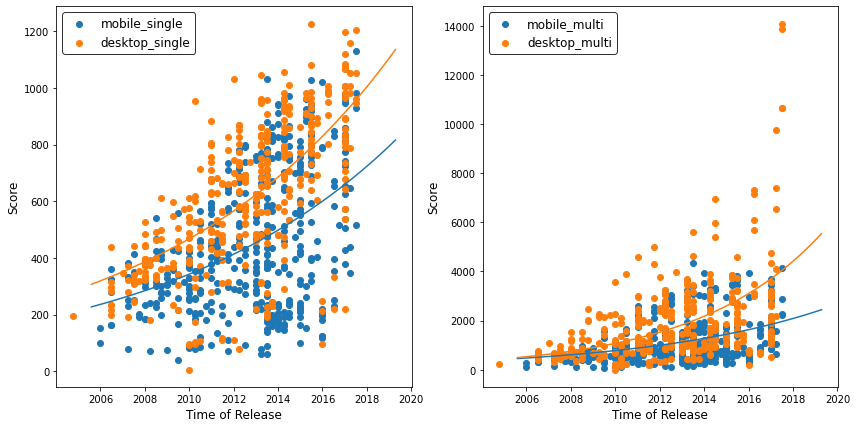

In [10]:
# the fit model used
def power(x, a, b):
    return a * np.power(2, b*x)

# to make sure the filter in the above section does not miss anything
df_desktop = df_with_score[df_with_score.Vertical_Segment == 'Desktop']
df_mobile = df_with_score[df_with_score.Vertical_Segment == 'Mobile']

# seperate desktop and mobile
mobile_launch_time = pd.to_datetime(df_mobile['Launch_Date'], unit='D')
mobile_single_core_perf = df_mobile['Geekbench_Single'].values
mobile_multi_core_perf = df_mobile['Geekbench_Multi'].values

desktop_launch_time = pd.to_datetime(df_desktop['Launch_Date'], unit='D')
desktop_single_core_perf = df_desktop['Geekbench_Single'].values
desktop_multi_core_perf = df_desktop['Geekbench_Multi'].values

# fit with the model
# x=#days since 1970, y=score
mobile_X = df_mobile['Launch_Date'].values
mobile_X = np.asarray([x.astype(float) for x in mobile_X])
mobile_y = df_mobile['Geekbench_Single'].values
mobile_model, _ = sp.optimize.curve_fit(f=power, xdata=mobile_X, ydata=mobile_y, p0=[0, 0])

desktop_X = df_desktop['Launch_Date'].values
desktop_X = np.asarray([x.astype(float) for x in desktop_X])
desktop_y = df_desktop['Geekbench_Single'].values
desktop_model, _ = sp.optimize.curve_fit(f=power, xdata=desktop_X, ydata=desktop_y, p0=[0, 0])

mobile_y_multi = df_mobile['Geekbench_Multi'].values
mobile_model_multi, _ = sp.optimize.curve_fit(f=power, xdata=mobile_X, ydata=mobile_y_multi, p0=[0, 0])

desktop_y_multi = df_desktop['Geekbench_Multi'].values
desktop_model_multi, _ = sp.optimize.curve_fit(f=power, xdata=desktop_X, ydata=desktop_y_multi, p0=[0, 0])

# generate scatter plot
plt.figure(figsize=(14,7))
plt.subplot(1, 2, 1)
plt.scatter(mobile_launch_time, mobile_single_core_perf, label='mobile_single', c='tab:blue')
plt.scatter(desktop_launch_time, desktop_single_core_perf, label='desktop_single', c='tab:orange')
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Score', fontsize=12)

# plot fit model
# from around 2005 to 2019, in #days
x_fit = np.linspace(13000, 18000, 100)
x_fit_time = [pd.to_datetime(x, unit='D') for x in x_fit]
plt.plot(x_fit_time, power(x_fit, mobile_model[0], mobile_model[1]))
plt.plot(x_fit_time, power(x_fit, desktop_model[0], desktop_model[1]))

# similarly, plot multi_score models
plt.subplot(1, 2, 2)
plt.scatter(mobile_launch_time, mobile_multi_core_perf, label='mobile_multi', c='tab:blue')
plt.scatter(desktop_launch_time, desktop_multi_core_perf, label='desktop_multi', c='tab:orange')
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.plot(x_fit_time, power(x_fit, mobile_model_multi[0], mobile_model_multi[1]))
plt.plot(x_fit_time, power(x_fit, desktop_model_multi[0], desktop_model_multi[1]))
plt.show()

As we may imagine, `Desktop` chips in general performs better than `Mobile` chips. Looking at the single-core performance, `Desktop` chips improved just slightly faster than `Mobile` chips. The difference is not significant. This makes sense because essentially these chips share similar architectures. 

Interestingly, on the other hand, `Desktop` chips improved a lot on multi-core performance over the past few years, especially on the high-end models. There are a few chips on 2017 that almost double the multi-core score compared to other chips. Before we discuss why this happens, let's quantify the improvements got by our model. 

In [11]:
print('Desktop single-core improvment by year: %s' % ('{0:.0%}'.format(np.power(2, desktop_model[1] * 365))))
print('Desktop multi-core improvment by year: %s' % ('{0:.0%}'.format(np.power(2, desktop_model_multi[1] * 365))))
print('Mobile single-core improvment by year: %s' % ('{0:.0%}'.format(np.power(2, mobile_model[1] * 365))))
print('Mobile multi-core improvment by year: %s' % ('{0:.0%}'.format(np.power(2, mobile_model_multi[1] * 365))))

Desktop single-core improvment by year: 110%
Desktop multi-core improvment by year: 119%
Mobile single-core improvment by year: 110%
Mobile multi-core improvment by year: 113%


See these numbers? If you are a computer DIY fan and you have seen Intel's new Core processor release news around those years (especially before AMD's Ryzen series came out), you are probably familiar with these percentages as they are quite close to the IPC (instruction per cycle) improvment that Intel claimed every time they announced new products.

### Historical trend

Now, let's figure out what makes the performace improvement, and what happened to `Desktop` processors' multi-core performance difference.

The cell below plots the changes in process node: `Lithography` and Thermal Design Point: `TDP` over the years. We can use these attributes to see how technological improvments made higher multi-core performance possible.

If you are not familiar with these terms, here is a brief introduction.

1. Process node describes the length of the transistor gate in semiconductor fabrication process. The smaller the node, the smaller the chip size and power consumption of a single transistor. It is harder to fabricate as the node goes down. Some used nodes in Intel CPUs: 90 nm, 65 nm, 45 nm, 32 nm, 22 nm, 14 nm, and the most recent 10 nm used in Intel's 11th gen. Tiger Lake chips.

2. TDP stands for Thermal Design Point. It describes the highest possible heat dissipation of a chip in daily use. The higher the TDP, the higher the power consumption. Increases in chip size and frequency could result in an increase in power consumption and TDP.

For process nodes plot, the larger the circle, the more products released with that node at that time.

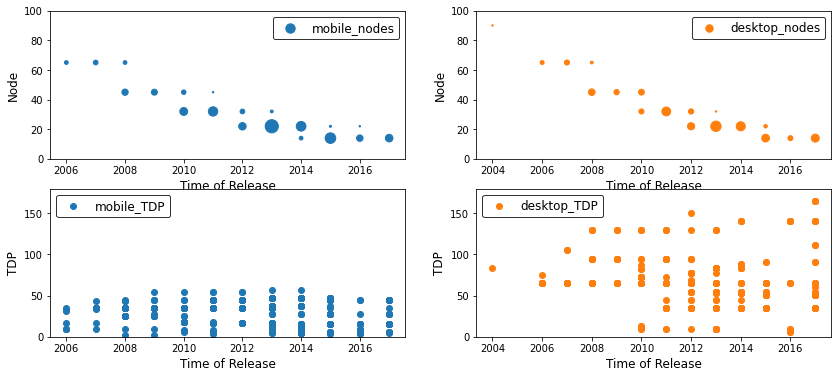

In [12]:
desktop_node = df_desktop['Lithography'].values
desktop_release_year = pd.to_datetime(df_desktop['Launch_Date'], unit='D').apply(lambda x: x.year).values
mobile_node = df_mobile['Lithography'].values
mobile_release_year = pd.to_datetime(df_mobile['Launch_Date'], unit='D').apply(lambda x: x.year).values
# preprocess data as tuples
desktop_year_node_tuple = []
for i in range(len(desktop_node)):
    desktop_year_node_tuple.append(tuple((desktop_node[i], desktop_release_year[i])))
desktop_years =  list(set(desktop_release_year))
desktop_years.sort()

mobile_year_node_tuple = []
for i in range(len(mobile_node)):
    mobile_year_node_tuple.append(tuple((mobile_node[i], mobile_release_year[i])))
mobile_years =  list(set(mobile_release_year))
mobile_years.sort()
# prepare bubble chart
desktop_node_list = []
desktop_year_list = []
desktop_size_list = []
for year in desktop_years:
    cnt = collections.Counter([x[0] for x in desktop_year_node_tuple if x[1] == year])
    for cnt_result in cnt.most_common():
        desktop_node_list.append(cnt_result[0])
        desktop_size_list.append(cnt_result[1] * 2)
        desktop_year_list.append(year)    
mobile_node_list = []
mobile_year_list = []
mobile_size_list = []
for year in mobile_years:
    cnt = collections.Counter([x[0] for x in mobile_year_node_tuple if x[1] == year])
    for cnt_result in cnt.most_common():
        mobile_node_list.append(cnt_result[0])
        mobile_size_list.append(cnt_result[1] * 2)
        mobile_year_list.append(year)
# plot
plt.figure(figsize=(14,6))
plt.subplot(2, 2, 2)
plt.ylim((0, 100))
plt.scatter(desktop_year_list, desktop_node_list, s=desktop_size_list, label='desktop_nodes', c='tab:orange')
plt.legend(loc=1, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Node', fontsize=12)
plt.subplot(2, 2, 1)
plt.ylim((0, 100))
plt.scatter(mobile_year_list, mobile_node_list, s=mobile_size_list, label='mobile_nodes', c='tab:blue')
plt.legend(loc=1, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Node', fontsize=12)
plt.subplot(2, 2, 4)
plt.ylim((0, 180))
plt.scatter(desktop_release_year, df_desktop['TDP'].values, label='desktop_TDP', c='tab:orange')
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('TDP', fontsize=12)
plt.subplot(2, 2, 3)
plt.ylim((0, 180))
plt.scatter(mobile_release_year, df_mobile['TDP'].values, label='mobile_TDP', c='tab:blue')
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('TDP', fontsize=12)
plt.show()


As we can see, the process node went down almost every two years. The decrease in process node should have decreased the power consumption, and TDP, if everything else remains the same.

However, this does not happen in the TDP plot. We see that TDPs remain steady over years. This is potentially because that recent chips either increase chip sizes or the frequency, or both, which should have resulted in an increase in power consumption. The decrease in process node helps balancing it, maintaining the same amount of overall power consumption.

In this case, let's see how chip size and frequency specfication actually changed.

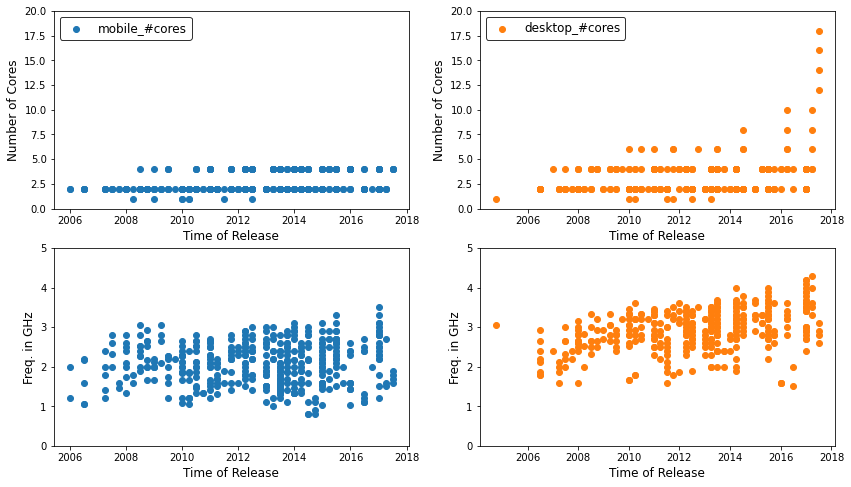

In [13]:
plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
mobile_core_num = df_mobile['nb_of_Cores'].values

plt.scatter(mobile_launch_time, mobile_core_num, label='mobile_#cores', c='tab:blue')
plt.ylim((0, 20))
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Number of Cores', fontsize=12)

plt.subplot(2, 2, 2)
desktop_core_num = df_desktop['nb_of_Cores'].values
plt.scatter(desktop_launch_time, desktop_core_num, label='desktop_#cores', c='tab:orange')
plt.ylim((0, 20))
plt.legend(loc=2, prop={'size': 12}, frameon=True, facecolor="white", edgecolor="black")
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Number of Cores', fontsize=12)

plt.subplot(2, 2, 3)
mobile_freq = df_mobile['Processor_Base_Frequency'].values
plt.scatter(mobile_launch_time, mobile_freq, label='mobile_base_freq', c='tab:blue')
plt.ylim((0, 5))
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Freq. in GHz', fontsize=12)

plt.subplot(2, 2, 4)
desktop_freq = df_desktop['Processor_Base_Frequency'].values
plt.scatter(desktop_launch_time, desktop_freq, label='desktop_base_freq', c='tab:orange')
plt.ylim((0, 5))
plt.xlabel('Time of Release', fontsize=12)
plt.ylabel('Freq. in GHz', fontsize=12)
plt.show()

Unlike `Mobile` chips, Intel kept increasing the number of cores in `Desktop` over the past few years. The increase in the number of cores is the reason that `Desktop` chips had a higher increase in multi-core performance.

## Real world application: which chip gives the highest performance per dollar you spend?
Finally, let's talk about some real-world application that the dataset can help you with. Suppose you are DIYing your computer, and you want to buy the best processor in terms of economic benefit. That is, you want the highest performance per dollar you spend. Let's plot how much performace you get divided by the recommanded price.

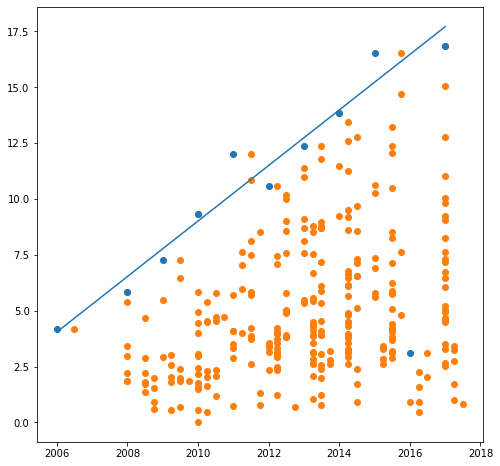

[861, 82, 854, 846, 830, 834, 789, 106, 111, 124, 114]


In [14]:
# linear fit model
def linear(x, a, b):
    return a * x + b

df_with_score_price = df_with_score.dropna(subset=['Recommended_Customer_Price'])
df_desktop = df_with_score_price[df_with_score_price.Vertical_Segment == 'Desktop']
df_mobile = df_with_score_price[df_with_score_price.Vertical_Segment == 'Mobile']

mobile_launch_time = pd.to_datetime(df_mobile['Launch_Date'], unit='D')
desktop_launch_time = pd.to_datetime(df_desktop['Launch_Date'], unit='D')

# calculate performance per dollar
df_desktop_perf_per_dollar = pd.DataFrame()
df_desktop_perf_per_dollar['Single_Perf_Per_Dollar'] = df_desktop.apply(lambda x: x.Geekbench_Single / x.Recommended_Customer_Price, axis=1)
df_desktop = df_desktop.join(df_desktop_perf_per_dollar)


launch_years = pd.to_datetime(df_desktop['Launch_Date'], unit='D').apply(lambda x: x.year).values
launch_years = list(set(launch_years))
launch_years.sort()

max_all_years = []
max_all_years_id = []
for launch_year in launch_years:
    df_per_year = df_desktop[pd.to_datetime(df_desktop['Launch_Date'], unit='D').apply(lambda x: x.year).values == launch_year]
    max_per_year = df_per_year['Single_Perf_Per_Dollar'].max()
    max_per_year_id = df_per_year['Single_Perf_Per_Dollar'].idxmax()
    max_all_years.append(max_per_year)
    max_all_years_id.append(max_per_year_id)
launch_years = [pd.to_datetime(x, format='%Y') for x in launch_years]
launch_years = [x.to_datetime64().astype('datetime64[D]').astype(float) for x in launch_years]  
    
desktop_model, _ = sp.optimize.curve_fit(f=linear, xdata=launch_years, ydata=max_all_years, p0=[0, 0])

x_fit = np.linspace(13000, 18000, 100)
launch_years = np.asarray(launch_years)
launch_years_time = [pd.to_datetime(x, unit='D') for x in launch_years]

plt.figure(figsize=(8,8))
plt.scatter(desktop_launch_time, df_desktop['Single_Perf_Per_Dollar'].values, c='tab:orange')
plt.scatter(launch_years_time, max_all_years)

# remove 2016, the outlier
launch_years = np.delete(launch_years, -2)
launch_years_time.pop(-2)
max_all_years = np.delete(max_all_years, -2)
desktop_model, _ = sp.optimize.curve_fit(f=linear, xdata=launch_years, ydata=max_all_years, p0=[0, 0]) 
plt.plot(launch_years_time, linear(launch_years, desktop_model[0], desktop_model[1]), c='tab:blue')
plt.show()
print(max_all_years_id)

The blue dots are the most economic chip every year. From these blue data points, we can see that it is almost a linear increase. The blue line is the least-square fit if we exclude the 2016 outlier. This is how technological improvment benefits us: every year we can get more performance out of a single penny we spend on processors.

How about the lonely blue data point in 2016? Let's see what are these economic competition winners.

In [15]:
df_desktop['Launch_Date'] = df_desktop['Launch_Date'].apply(lambda x: pd.to_datetime(x, unit='D').year)
print_list = [
    'Product_Collection',
    'Vertical_Segment',
    'Processor_Number',
    'Launch_Date',
    'Recommended_Customer_Price',
    'Geekbench_Single',
    'Single_Perf_Per_Dollar'
]
df_desktop.loc[max_all_years_id][print_list]

,Product_Collection,Vertical_Segment,Processor_Number,Launch_Date,Recommended_Customer_Price,Geekbench_Single,Single_Perf_Per_Dollar
861,Legacy Intel® Celeron® Processor,Desktop,E1500,2006,47.0,197.0,4.191489
82,Legacy Intel® Pentium® Processor,Desktop,E6500,2008,68.0,396.0,5.823529
854,Legacy Intel® Celeron® Processor,Desktop,E3300,2009,47.0,342.0,7.276596
846,Legacy Intel® Celeron® Processor,Desktop,E3400,2010,42.0,392.0,9.333333
830,Legacy Intel® Celeron® Processor,Desktop,G540,2011,40.0,481.0,12.025000
834,Legacy Intel® Celeron® Processor,Desktop,G550,2012,42.0,444.0,10.571429
789,Intel® Pentium® Processor G Series,Desktop,G3220,2013,54.0,667.0,12.351852
106,Intel® Celeron® Processor G Series,Desktop,G1820T,2014,42.0,581.0,13.833333
111,Intel® Celeron® Processor G Series,Desktop,G3900,2015,42.0,694.0,16.523810
124,Intel® Celeron® Processor J Series,Desktop,J3355,2016,107.0,333.0,3.112150


As we can see, they are either Celeron E/G series or Pentium G Series, except for the 2016 winner. Celeron G and Pentium E/G processors were specfically designed for medium performance and low cost, reusing Core series microarchitectures to target low markets. That is why they are the most economic ones.

Why 2016's winner is a Celeron J processor? It is simply because Intel did not release new Celeron G and Pentium G in 2016.

https://ark.intel.com/content/www/us/en/ark/products/series/77772/intel-pentium-processor-g-series.html#@Desktop

https://ark.intel.com/content/www/us/en/ark/products/series/90613/intel-celeron-processor-g-series.html#@Desktop


## Further resources
If you are interested in the Moore's Law, you can take a look at this original journal from Gordon E. Moore\
https://newsroom.intel.com/wp-content/uploads/sites/11/2018/05/moores-law-electronics.pdf

... And a brief talk from him\
https://www.youtube.com/watch?v=EzyJxAP6AQo&ab_channel=ASML \
It is particularly interesting when he mentioned that it is not the industry trend that magically follows the Moore's Law, but the Moore's Law is driving the industry. There are many, many approaches that the industry is taking / have taken in order to catch up with Moore's Law's prediction, for instance, ASML's EUV, Intel's FinFET layout, etc. They together created the technological progress that make the statement at the end of Historical trend analysis come true.

If you are interested in some techniques they used: \
https://www.youtube.com/watch?v=f0gMdGrVteI&ab_channel=Seeker